<a href="https://colab.research.google.com/github/rahiakela/deep-learning-with-python-francois-chollet/blob/6-deep-learning-for-text-and-sequences/2_working_with_text_data__word_embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Working with text data: word embeddings

Text is one of the most widespread forms of sequence data. It can be understood as either a sequence of characters or a sequence of words, but it’s most common to work at the level of words.

The deep-learning sequence-processing models can use text to produce a basic form of natural-language understanding, sufficient for applications including:

* document classification, 
* sentiment analysis, 
* author identification, 
* and even question-answering (QA)

Of course, keep in mind that none of these deeplearning models truly understand text in a human sense; rather, these models can map the statistical structure of written language, which is sufficient to solve many simple textual tasks. 

Deep learning for natural-language processing is pattern recognition
applied to words, sentences, and paragraphs, in much the same way that computer vision is pattern recognition applied to pixels.

Like all other neural networks, deep-learning models don’t take as input raw text: they only work with numeric tensors. **Vectorizing text** is the process of transforming text into numeric tensors. 

This can be done in multiple ways:
* Segment text into words, and transform each word into a vector.
* Segment text into characters, and transform each character into a vector.
* Extract n-grams of words or characters, and transform each n-gram into a vector.N-grams are overlapping groups of multiple consecutive words or characters.

Collectively, the different units into which you can break down text (words, characters, or n-grams) are called tokens, and breaking text into such tokens is called tokenization. All text-vectorization processes consist of applying some tokenization scheme and then associating numeric vectors with the generated tokens. These vectors, packed into sequence tensors, are fed into deep neural networks. 

There are multiple ways to associate a vector with a token. I’ll present two major ones: 

* one-hot encoding of tokens, 
* and token embedding (typically used exclusively for words, and called
word embedding).

<img src='https://github.com/rahiakela/img-repo/blob/master/deep-learning-with-python/text-to-tokens-to-vectors.png?raw=1' width='800'/>

## Setup

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Embedding

from tensorflow.keras.datasets import imdb

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import numpy as np
import pandas as pd

import string
import os

import matplotlib.pyplot as plt
%matplotlib inline

## Using word embeddings

Another popular and powerful way to associate a vector with a word is the use of dense word vectors, also called word embeddings. Whereas the vectors obtained through one-hot encoding are binary, sparse (mostly made of zeros), and very high-dimensional (same dimensionality as the number of words in the vocabulary), word embeddings are lowdimensional floating-point vectors (that is, dense vectors, as opposed to sparse vectors).

Unlike word vectors obtained via one-hot encoding, word embeddings are learned from data. It is common to see word embeddings that are 256-dimensional, 512-dimensional, or 1024-dimensional when dealing with very large vocabularies. On the other hand, one-hot encoding words generally leads to vectors that are 20,000-dimensional or higher (capturing a vocabulary of 20,000 token in this case). So, word embeddings pack more information into far fewer dimensions.

<img src='https://s3.amazonaws.com/book.keras.io/img/ch6/word_embeddings.png?raw=1' width='800'/>

There are two ways to obtain word embeddings:

* Learn word embeddings jointly with the main task you care about (e.g. document classification or sentiment prediction). In this setup, you would start with random word vectors, then learn your word vectors in the same way that you learn the weights of a neural network.
* Load into your model word embeddings that were pre-computed using a different machine learning task than the one you are trying to solve. These are called "pre-trained word embeddings".


### Learning word embeddings with the Embedding layer

The simplest way to associate a dense vector to a word would be to pick the vector at random. The problem with this approach is that the resulting embedding space would have no structure: for instance, the words "accurate" and "exact" may end up with completely different embeddings, even though they are interchangeable in most sentences. It would be very difficult for a deep neural network to make sense of such a noisy, unstructured embedding space.

To get a bit more abstract: the geometric relationships between word vectors should reflect the semantic relationships between these words. Word embeddings are meant to map human language into a geometric space. For instance, in a reasonable embedding space, we would expect synonyms to be embedded into similar word vectors, and in general we would expect the geometric distance (e.g. L2 distance) between any two word vectors to relate to the semantic distance of the associated words (words meaning very different things would be embedded to points far away from each other, while related words would be closer). Even beyond mere distance, we may want specific directions in the embedding space to be meaningful.

It is thus reasonable to learn a new embedding space with every new task. Thankfully, backpropagation makes this really easy, and Keras makes it even easier. It's just about learning the weights of a layer: the Embedding layer.

```python
from keras.layers import Embedding

# The Embedding layer takes at least two arguments:
# the number of possible tokens, here 1000 (1 + maximum word index),
# and the dimensionality of the embeddings, here 64.
embedding_layer = Embedding(1000, 64)
```

The Embedding layer is best understood as a dictionary mapping integer indices (which stand for specific words) to dense vectors. It takes as input integers, it looks up these integers into an internal dictionary, and it returns the associated vectors. It's effectively a dictionary lookup.

```python
Word index >> Embedding layer >> Corresponding word vector
```

The Embedding layer takes as input a 2D tensor of integers, of shape (samples, sequence_length), where each entry is a sequence of integers. It can embed sequences of variable lengths, so for instance we could feed into our embedding layer above batches that could have shapes (32, 10) (batch of 32 sequences of length 10) or (64, 15) (batch of 64 sequences of length 15). All sequences in a batch must have the same length, though (since we need to pack them into a single tensor), so sequences that are shorter than others should be padded with zeros, and sequences that are longer should be truncated.

This layer returns a 3D floating point tensor, of shape (samples, sequence_length, embedding_dimensionality). Such a 3D tensor can then be processed by a RNN layer or a 1D convolution layer.

When you instantiate an Embedding layer, its weights (its internal dictionary of token vectors) are initially random, just like with any other layer. During training, these word vectors will be gradually adjusted via backpropagation, structuring the space into something that the downstream model can exploit. Once fully trained, your embedding space will show a lot of structure -- a kind of structure specialized for the specific problem you were training your model for.

Let's apply this idea to the IMDB movie review sentiment prediction task that you are already familiar with. Let's quickly prepare the data. We will restrict the movie reviews to the top 10,000 most common words (like we did the first time we worked with this dataset), and cut the reviews after only 20 words. Our network will simply learn 8-dimensional embeddings for each of the 10,000 words, turn the input integer sequences (2D integer tensor) into embedded sequences (3D float tensor), flatten the tensor to 2D, and train a single Dense layer on top for classification.


In [3]:
# Number of words to consider as features
max_features = 10000

# Cut texts after this number of words (among top max_features most common words)
maxlen = 20

# Load the data as lists of integers.
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

# turns our lists of integers into a 2D integer tensor of shape `(samples, maxlen)`
x_train = pad_sequences(x_train, maxlen=maxlen)
x_test = pad_sequences(x_test, maxlen=maxlen)

17465344/17464789 [==============================] - 0s 0us/step


In [0]:
model = Sequential()

# specify the maximum input length to our Embedding layer so we can later flatten the embedded inputs
model.add(Embedding(10000, 8, input_length=maxlen))
# After the Embedding layer, our activations have shape `(samples, maxlen, 8)`.

# flatten the 3D tensor of embeddings into a 2D tensor of shape `(samples, maxlen * 8)`
model.add(Flatten())

# We add the classifier on top
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 20, 8)             80000     
_________________________________________________________________
flatten (Flatten)            (None, 160)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 161       
Total params: 80,161
Trainable params: 80,161
Non-trainable params: 0
_________________________________________________________________


In [0]:
history = model.fit(x_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
625/625 [==============================] - 2s 3ms/step - loss: 0.6701 - accuracy: 0.6220 - val_loss: 0.6212 - val_accuracy: 0.7000
Epoch 2/10
625/625 [==============================] - 2s 3ms/step - loss: 0.5425 - accuracy: 0.7494 - val_loss: 0.5268 - val_accuracy: 0.7392
Epoch 3/10
625/625 [==============================] - 2s 3ms/step - loss: 0.4615 - accuracy: 0.7857 - val_loss: 0.5006 - val_accuracy: 0.7512
Epoch 4/10
625/625 [==============================] - 2s 3ms/step - loss: 0.4229 - accuracy: 0.8067 - val_loss: 0.4936 - val_accuracy: 0.7578
Epoch 5/10
625/625 [==============================] - 2s 3ms/step - loss: 0.3973 - accuracy: 0.8236 - val_loss: 0.4945 - val_accuracy: 0.7602
Epoch 6/10
625/625 [==============================] - 2s 3ms/step - loss: 0.3769 - accuracy: 0.8340 - val_loss: 0.4958 - val_accuracy: 0.7636
Epoch 7/10
625/625 [==============================] - 2s 3ms/step - loss: 0.3573 - accuracy: 0.8473 - val_loss: 0.5002 - val_accuracy: 0.7608
Epoch 

We get to a validation accuracy of ~76%, which is pretty good considering that we only look at the first 20 words in every review. But note that merely flattening the embedded sequences and training a single Dense layer on top leads to a model that treats each word in the input sequence separately, without considering inter-word relationships and structure sentence (e.g. it would likely treat both "this movie is shit" and "this movie is the shit" as being negative "reviews"). It would be much better to add recurrent layers or 1D convolutional layers on top of the embedded sequences to learn features that take into account each sequence as a whole. That's what we will focus on in the next few sections.

### Using pre-trained word embeddings

Sometimes, you have so little training data available that could never use your data alone to learn an appropriate task-specific embedding of your vocabulary. What to do then?

Instead of learning word embeddings jointly with the problem you want to solve, you could be loading embedding vectors from a pre-computed embedding space known to be highly structured and to exhibit useful properties -- that captures generic aspects of language structure. 

The rationale behind using pre-trained word embeddings in natural language processing is very much the same as for using pre-trained convnets in image classification: we don't have enough data available to learn truly powerful features on our own, but we expect the features that we need to be fairly generic, i.e. common visual features or semantic features. In this case it makes sense to reuse features learned on a different problem.

Such word embeddings are generally computed using word occurrence statistics (observations about what words co-occur in sentences or documents), using a variety of techniques, some involving neural networks, others not. The idea of a dense, low-dimensional embedding space for words, computed in an unsupervised way, was initially explored by Bengio et al. in the early 2000s, but it only started really taking off in research and industry applications after the release of one of the most famous and successful word embedding scheme: the Word2Vec algorithm, developed by Mikolov at Google in 2013. Word2Vec dimensions capture specific semantic properties, e.g. gender.

There are various pre-computed databases of word embeddings that can download and start using in a Keras Embedding layer. 

* Word2Vec is one of them. 
* Another popular one is called "GloVe", developed by Stanford researchers in 2014. It stands for "Global Vectors for Word Representation", and it is an embedding technique based on factorizing a matrix of word co-occurrence statistics. 

Let's take a look at how you can get started using GloVe embeddings in a Keras model. The same method will of course be valid for Word2Vec embeddings or any other word embedding database that you can download. We will also use this example to refresh the text tokenization techniques we introduced a few paragraphs ago: we will start from raw text, and work our way up.

## Putting it all together: from raw text to word embeddings

You’ll use a model similar to the one we just went over: 

* embedding sentences in sequences of vectors, 
* flattening them, 
* and training a Dense layer on top. 

But you’ll do so using pretrained word embeddings; and instead of using the pretokenized IMDB data packaged in Keras, you’ll start from scratch by downloading the original text data.

### Download the IMDB data as raw text

In [4]:
# download IMDB dataset
ds_path = keras.utils.get_file('aclImdb_v1.tar.gz', origin='http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz', extract=True)
ds_path

84131840/84125825 [==============================] - 7s 0us/step


'/root/.keras/datasets/aclImdb_v1.tar.gz'

In [0]:
!cp /root/.keras/datasets/aclImdb_v1.tar.gz .

In [0]:
import tarfile

tar = tarfile.open('aclImdb_v1.tar.gz', "r:gz")
tar.extractall()
tar.close()

In [0]:
imdb_dir = 'aclImdb/'
train_dir = os.path.join(imdb_dir, 'train')

labels = []
texts = []

for label_type in ['neg', 'pos']:
  dir_name = os.path.join(train_dir, label_type)
  for fname in os.listdir(dir_name):
    f = open(os.path.join(dir_name, fname))
    texts.append(f.read())
    f.close()
    if label_type == 'neg':
      labels.append(0)
    else:
      labels.append(1)

In [8]:
texts[:5]

['I saw this movie a few days ago and gamely jumped during the scary parts. I must admit, I found it pretty decent...until I started to THINK about what the characters were saying. Logical problems:<br /><br />1. Her boyfriend, who seems to be a pretty fit dude, makes no sound while being killed. Don\'t you think that he might have at least tried to take the killer? <br /><br />2. When the remark is made that the gym teacher is "SOOOO in love with Lisa," I almost screamed at the screen. When your best friend\'s family HAS BEEN KILLED BY A TEACHER WHO WAS IN LOVE WITH HER, you don\'t make comments like that if you have half of a heart.<br /><br />3. As soon as Nash asks the uncle how many exits they have in the house and the uncle catches on that there may be danger ahead, wouldn\'t the smart thing to do be to get Donna, boyfriend, aunt, and uncle into a car and drive far, far away, then bait the house with the HRT and police force so that the killer has no way to get out?<br /><br />I 

In [9]:
labels[:5]

[0, 0, 0, 0, 0]

In [10]:
(len(texts), len(labels))

(25000, 25000)

### Tokenize the data

Let's vectorize the texts we collected, and prepare a training and validation split. We will merely be using the concepts we introduced earlier in this section.

Because pre-trained word embeddings are meant to be particularly useful on problems where little training data is available (otherwise, task-specific embeddings are likely to outperform them), we will add the following twist: we restrict the training data to its first 200 samples. So we will be learning to classify movie reviews after looking at just 200 examples...

In [11]:
maxlen = 100                # We will cut reviews after 100 words
training_samples = 200      # We will be training on 200 samples
validation_samples = 10000  # We will be validating on 10000 samples
max_words = 10000           # We will only consider the top 10,000 words in the dataset

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print(f'Found {str(len(word_index))} unique tokens.')

data = pad_sequences(sequences, maxlen=maxlen)
labels = np.asarray(labels)
print(f'Shape of data tensor: {data.shape}')
print(f'Shape of label tensor: {labels.shape}')

'''
Split the data into a training set and a validation set
But first, shuffle the data, since we started from data
where sample are ordered (all negative first, then all positive).
'''
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

Found 88582 unique tokens.
Shape of data tensor: (25000, 100)
Shape of label tensor: (25000,)


## Download the GloVe word embeddings

Head to https://nlp.stanford.edu/projects/glove/ (where you can learn more about the GloVe algorithm), and download the pre-computed embeddings from 2014 English Wikipedia. It's a 822MB zip file named glove.6B.zip, containing 100-dimensional embedding vectors for 400,000 words (or non-word tokens). Un-zip it.

In [12]:
# download IMDB dataset
glove_path = keras.utils.get_file('glove.6B.zip', origin='http://nlp.stanford.edu/data/glove.6B.zip', extract=True)
glove_path

862183424/862182613 [==============================] - 390s 0us/step


'/root/.keras/datasets/glove.6B.zip'

In [0]:
!cp -r /root/.keras/datasets/glove.6B.zip .

In [0]:
import zipfile
with zipfile.ZipFile('glove.6B.zip', 'r') as zip_ref:
    zip_ref.extractall('glove')

### Pre-process the embeddings

Let's parse the un-zipped file (it's a txt file) to build an index mapping words (as strings) to their vector representation (as number vectors).

In [15]:
glove_dir = 'glove/'

embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))
for line in f:
  values = line.split()
  word = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
f.close()

print(f'Found {str(len(embeddings_index))} word vectors.')

Found 400000 word vectors.


### Preparing the GloVe word-embeddings matrix

Now let's build an embedding matrix that we will be able to load into an Embedding layer. It must be a matrix of shape (max_words, 
embedding_dim), where each entry i contains the embedding_dim-dimensional vector for the word of index i in our reference word index (built during tokenization). Note that the index 0 is not supposed to stand for any word or token -- it's a placeholder.

In [0]:
embedding_dim = 100

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
  embedding_vector = embeddings_index.get(word)
  if i < max_words:
    if embedding_vector is not None:
      # Words not found in embedding index will be all-zeros.
      embedding_matrix[i] = embedding_vector

## Define a model

You’ll use the same model architecture as before.

In [17]:
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          1000000   
_________________________________________________________________
flatten (Flatten)            (None, 10000)             0         
_________________________________________________________________
dense (Dense)                (None, 32)                320032    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


### Load the GloVe embeddings in the model

The Embedding layer has a single weight matrix: a 2D float matrix where each entry i is the word vector meant to be associated with index i. Simple enough. Let's just load the GloVe matrix we prepared into our Embedding layer, the first layer in our model:

In [0]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

Additionally, we freeze the embedding layer (we set its trainable attribute to False), following the same rationale as what you are already familiar with in the context of pre-trained convnet features: when parts of a model are pre-trained (like our Embedding layer), and parts are randomly initialized (like our classifier), the pre-trained parts should not be updated during training to avoid forgetting what they already know. The large gradient update triggered by the randomly initialized layers would be very disruptive to the already learned features.

### Train and evaluate

Let's compile our model and train it:

In [19]:
model.compile(optimizer='RMSprop', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_val, y_val))
model.save_weights('pre_trained_glove_model.h5')

Epoch 1/10
7/7 [==============================] - 1s 154ms/step - loss: 1.5567 - accuracy: 0.5150 - val_loss: 0.7849 - val_accuracy: 0.5047
Epoch 2/10
7/7 [==============================] - 1s 128ms/step - loss: 0.6059 - accuracy: 0.6550 - val_loss: 0.8547 - val_accuracy: 0.5047
Epoch 3/10
7/7 [==============================] - 1s 136ms/step - loss: 0.4956 - accuracy: 0.7750 - val_loss: 0.6833 - val_accuracy: 0.5698
Epoch 4/10
7/7 [==============================] - 1s 127ms/step - loss: 0.2952 - accuracy: 0.9250 - val_loss: 0.8442 - val_accuracy: 0.5221
Epoch 5/10
7/7 [==============================] - 1s 129ms/step - loss: 0.2802 - accuracy: 0.8950 - val_loss: 1.1398 - val_accuracy: 0.4988
Epoch 6/10
7/7 [==============================] - 1s 130ms/step - loss: 0.2606 - accuracy: 0.8900 - val_loss: 0.7497 - val_accuracy: 0.5543
Epoch 7/10
7/7 [==============================] - 1s 128ms/step - loss: 0.1115 - accuracy: 0.9950 - val_loss: 0.7532 - val_accuracy: 0.5735
Epoch 8/10
7/7 [====

Let's plot its performance over time:

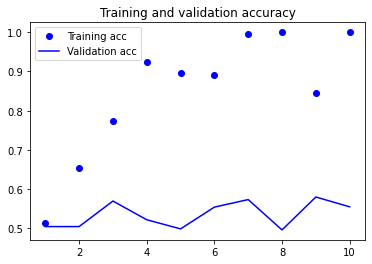

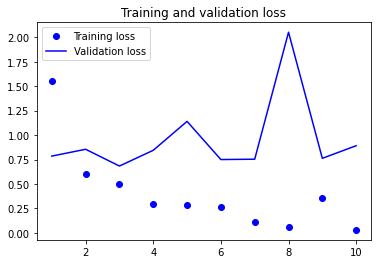

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

The model quickly starts overfitting, unsurprisingly given the small number of training samples. Validation accuracy has high variance for the same reason, but seems to reach high 50s.

Note that your mileage may vary: since we have so few training samples, performance is heavily dependent on which exact 200 samples we picked, and we picked them at random. If it worked really poorly for you, try picking a different random set of 200 samples, just for the sake of the exercise (in real life you don't get to pick your training data).

We can also try to train the same model without loading the pre-trained word embeddings and without freezing the embedding layer. In that case, we would be learning a task-specific embedding of our input tokens, which is generally more powerful than pre-trained word embeddings when lots of data is available. However, in our case, we have only 200 training samples. Let's try it:

In [22]:
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(optimizer='RMSprop', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_val, y_val))
model.save_weights('pre_trained_glove_model.h5')

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_2 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
7/7 [==============================] - 1s 148ms/step - loss: 0.7016 - accuracy: 0.4500 - val_loss: 0.6926 - val_accuracy: 0.5105
Epoch 2/10
7/7 [==============================] - 1s 136ms/step - loss: 0.5123 - accuracy: 0.9850 - va

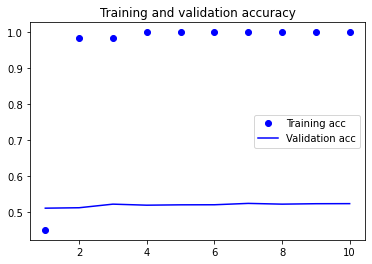

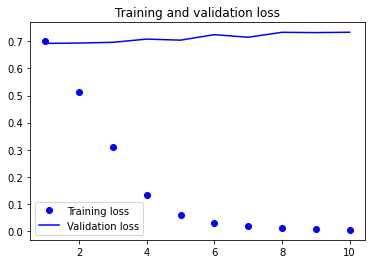

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Validation accuracy stalls in the low 50s. So in our case, pre-trained word embeddings does outperform jointly learned embeddings. If you increase the number of training samples, this will quickly stop being the case -- try it as an exercise.

Finally, let's evaluate the model on the test data. First, we will need to tokenize the test data:

In [0]:
test_dir = os.path.join(imdb_dir, 'test')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(test_dir, label_type)
    for fname in sorted(os.listdir(dir_name)):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

sequences = tokenizer.texts_to_sequences(texts)
x_test = pad_sequences(sequences, maxlen=maxlen)
y_test = np.asarray(labels)

And let's load and evaluate the first model:

In [25]:
model.load_weights('pre_trained_glove_model.h5')
model.evaluate(x_test, y_test)

782/782 [==============================] - 2s 3ms/step - loss: 0.7289 - accuracy: 0.5320


[0.728891909122467, 0.5320000052452087]

We get an appalling test accuracy of 54%. Working with just a handful of training samples is hard!